In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.cross_validation import train_test_split
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

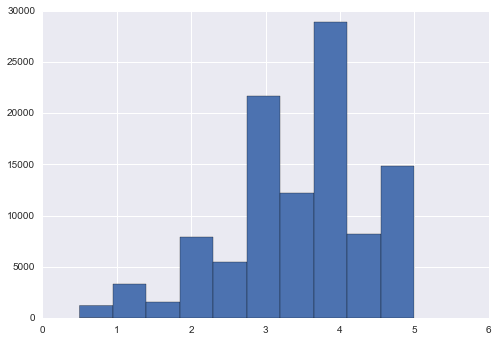

In [29]:
ratings = pd.DataFrame.from_csv('ratings.csv',index_col=None)
movies = pd.DataFrame.from_csv('movies.csv',index_col='movieId')
ratings = ratings.drop('timestamp',axis=1)
all = pd.merge(ratings, movies.reset_index(), on='movieId')

genres = []
length = len(all)
for num in range(0,length):
    text = all.genres[num]
    while '|' in text:
        g,sep,text = text.partition('|')
        if g not in genres:
            genres.append(g)
    if text not in genres:
        genres.append(text)
genres.sort()

plt.hist(all.rating)
genres

C:\Users\Somil\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


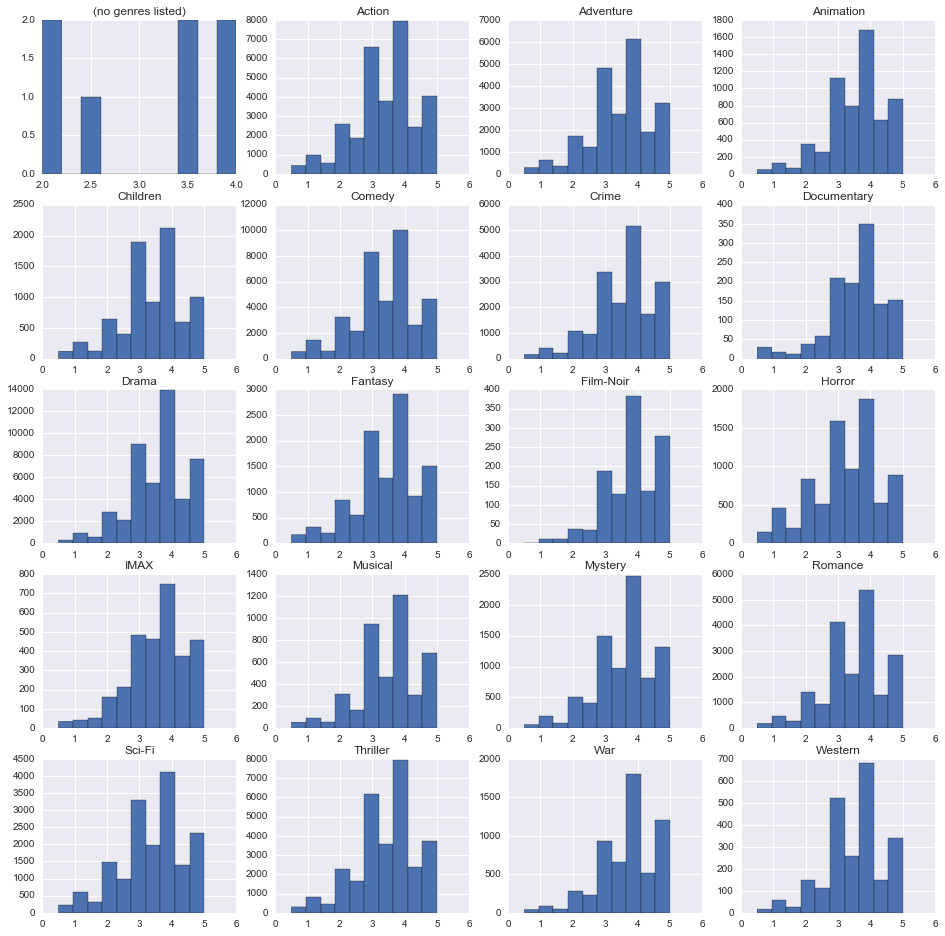

In [27]:
fig,axes = plt.subplots(nrows=5, ncols = 4, figsize = (16,16))

for num in range(0,axes.shape[0]):
    for num2 in range(0,axes.shape[1]):
        axes[num,num2].hist(all[all.genres.str.contains(genres[num*axes.shape[1] + num2])].rating)
        axes[num,num2].set_title(genres[num*axes.shape[1] + num2])

In [34]:
r = ratings
r = r.set_index('userId')
r['user_freq'] = r.index.value_counts()
r = r[(r.user_freq <= 1500)&(r.user_freq >= 40)]
r = r.reset_index()
r = r.set_index('movieId')
r['movie_freq'] = r.index.value_counts()
r = r[r.movie_freq >=40]
r = r.reset_index()
r = r.drop(['user_freq','movie_freq'],axis=1)

same_shape = False
while same_shape == False:
    tr, test = train_test_split(r, train_size = 0.7) #, random_state = 0)
    trm = tr.pivot('movieId','userId','rating')
    testm = test.pivot('movieId','userId','rating')
    if (trm.shape == testm.shape):
        same_shape = True
        
ind = trm.index
col = trm.columns
    
mu = trm.mean(axis = 1)
trm2 = trm.subtract(mu,axis=0)
R = np.asarray(~np.isnan(trm2)) #Matrix containing boolean for rated/not rated for each movie user pairing
trm2 = np.asarray(trm2.fillna(0))
    
nmovies, nusers = trm2.shape

nfeatures = 250
reg = 10

X = np.random.randn(nmovies,nfeatures) #movie features
Theta = np.random.randn(nusers,nfeatures) #user features

alpha = .003 #learning rate

delta = 1
iter = 0
J = []
J_new = np.sum(np.sum(np.multiply(((np.dot(X,np.transpose(Theta))-trm2)**2),R)))/2 + reg/2*(np.sum(np.sum(Theta**2))+np.sum(np.sum(X**2)))
J.append({'Iteration': iter, 'Cost': J_new})
while delta >= 0.001:
    J_old = J_new
    iter = iter+1
    X_grad = np.dot(np.multiply(np.dot(X,np.transpose(Theta))-trm2,R),Theta) + reg*X
    Theta_grad = np.dot(np.transpose(np.multiply(np.dot(X,np.transpose(Theta))-trm2,R)),X)+reg*Theta
    X = X-alpha*X_grad
    Theta = Theta-alpha*Theta_grad
    J_new = np.sum(np.sum(np.multiply(((np.dot(X,np.transpose(Theta))-trm2)**2),R)))/2 + reg/2*(np.sum(np.sum(Theta**2))+np.sum(np.sum(X**2)))
    J.append({'Iteration': iter, 'Cost': J_new})
    delta = (J_old-J_new)/J_old
    if delta <0:
        X = X+alpha*X_grad
        Theta = Theta+alpha*Theta_grad
        J_new = J_old
        alpha = alpha/3
        delta=1
                
Predictions = pd.DataFrame(data = np.dot(X,np.transpose(Theta)),index = ind, columns = col)
Predictions = Predictions.add(mu,axis = 0)
n_obs= np.sum(np.sum(~np.isnan(testm)))
            
RMSE_avg = math.sqrt(np.sum(np.sum((testm.subtract(mu,axis = 0))**2))/n_obs)
RMSE_alg = math.sqrt(np.sum(np.sum((Predictions - testm)**2))/n_obs)
red = (RMSE_avg - RMSE_alg)/RMSE_avg*100

C:\Users\Somil\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\Users\Somil\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


0.93745430032793398

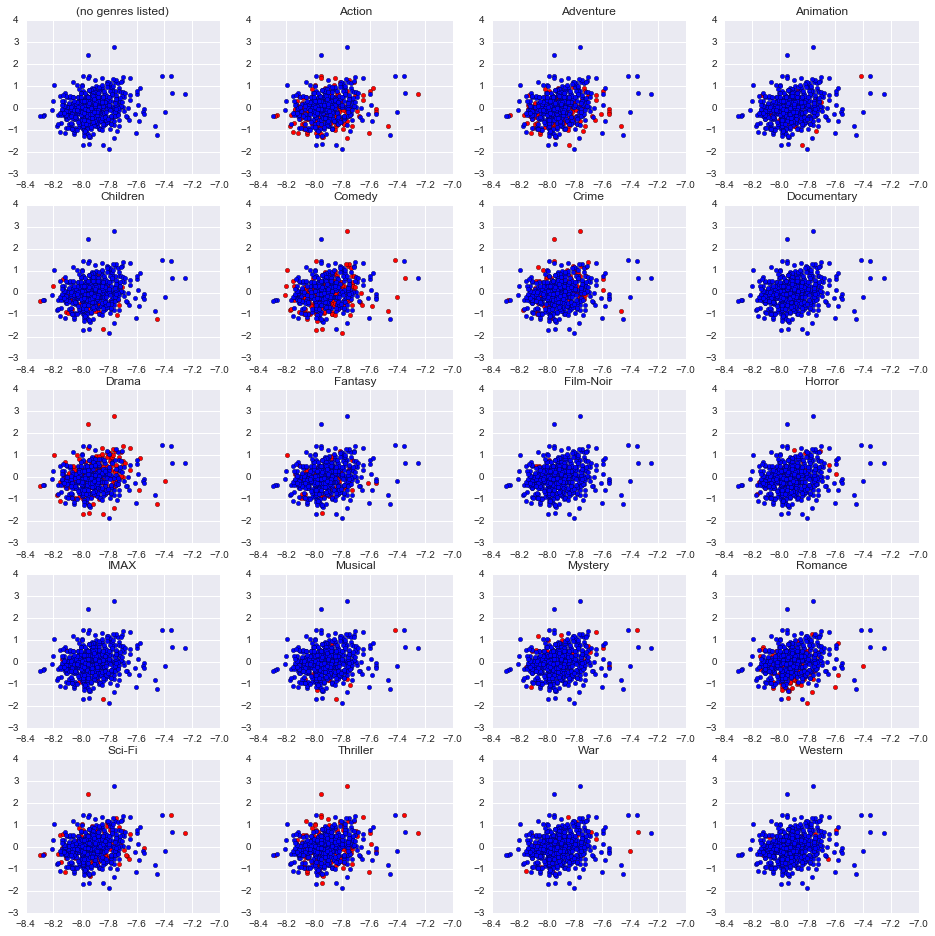

In [83]:
#Dimensionality Reduction by Principal Component Analysis
#Mean normalization of features
mu2 = X.mean(axis=0)
X_norm = X-mu2

#Feature Scaling
X_proc = (X_norm-X_norm.min(axis = 0))/(X_norm.max(axis = 0) - X_norm.min(axis =0))

#PCA
ndim = 2
X_sig = np.dot(X_proc.transpose(),X_proc)/nmovies
[U_X,S_X,V_X] = np.linalg.svd(X_sig)
U_red_X = U_X[:,0:ndim] #Reducing to n dimensions
Z_X = np.dot(U_red.transpose(),X_proc.transpose()).transpose()
Z_X = pd.DataFrame(Z_X, index = ind)
X_approx = np.dot(U_red,Z_X.transpose()).transpose()

mov = pd.merge(Z_X.reset_index(), movies.reset_index(), on='movieId')

fig,axes = plt.subplots(nrows=5, ncols = 4, figsize = (16,16))

for num in range(0,axes.shape[0]):
    for num2 in range(0,axes.shape[1]):
        a = mov[mov.genres.str.contains(genres[num*axes.shape[1]+num2])]
        b = mov[~mov.genres.str.contains(genres[num*axes.shape[1]+num2])]
        axes[num,num2].scatter(a[0],a[1], c='r')
        axes[num,num2].scatter(b[0],b[1], c='b')
        axes[num,num2].set_title(genres[num*axes.shape[1] + num2])

np.sum(S_X[0:ndim])/np.sum(S_X)

0.95995744339942002

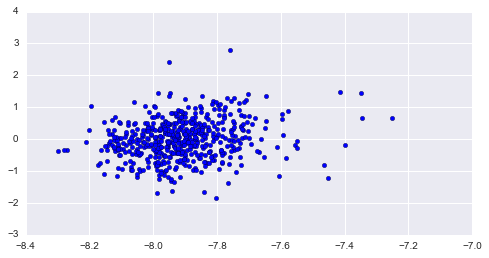

In [52]:
#Dimensionality Reduction by Principal Component Analysis
#Mean normalization of features
mu3 = Theta.mean(axis=0)
Theta_norm = Theta-mu3
#Feature Scaling
Theta_proc = (Theta_norm-Theta_norm.min(axis = 0))/(Theta_norm.max(axis = 0)-Theta_norm.min(axis =0))

#PCA
ndim = 2
Theta_sig = np.dot(Theta_proc.transpose(),Theta_proc)/nmovies
[U_Theta,S_Theta,V_Theta] = np.linalg.svd(Theta_sig)
U_red_Theta = U_Theta[:,0:ndim] #Reducing to n dimensions
Z_Theta = np.dot(U_red.transpose(),Theta_proc.transpose()).transpose()
Theta_approx = np.dot(U_red_Theta,Z_Theta.transpose()).transpose()

fig, axes = plt.subplots(1,1,figsize=(8,4))
axes.scatter(Z[:,0], Z[:,1])

np.sum(S_Theta[0:ndim])/np.sum(S_Theta) #variance retention